In [1]:
import json as js
from matplotlib.pyplot import boxplot
import pandas as pd

Read list of measurements and return them as sorted list descending by signal strength.
A measurement is a tuple of the serial, a timestamp and the signal strength.

In [2]:
def convert_measurements(val):
    measurements = js.loads(val)
    measurements_list = []
    for m in measurements:
        serial = m[0]
        timestamp = m[1]
        signal_strength = m[2]
        measurements_list.append((serial, timestamp, signal_strength))

    return sorted(measurements_list, key = lambda msmt: msmt[2], reverse=True)

Select top 3 measurements with the strongest signal strength and reliable sensor.
The sensor of type 'GRX1090' has some strong outliers, these are removed.
Duplicate strongest measurement if there are less than 3 measurements available.

In [3]:
def select_measurements(measurements, reliable_sensors):
    selection = [(serial, timestamp, signal_strength) for serial, timestamp, signal_strength in measurements if signal_strength < 200 and serial in reliable_sensors]
    if len(selection) >= 3:
        return selection[0:2]
    else:
        while len(selection) < 3:
            selection.append(selection[0])
        return selection

In [4]:
aircrafts_data_df = pd.read_csv('training_6_category_1/training_6_category_1.csv', index_col='id', converters={'measurements': convert_measurements})
sensors_df = pd.read_csv('training_6_category_1/sensors.csv', index_col='serial', dtype={'type': 'category'})

In [5]:
aircrafts_data_df.info()
aircrafts_data_df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1930138 entries, 1 to 1930138
Data columns (total 8 columns):
 #   Column           Dtype  
---  ------           -----  
 0   timeAtServer     float64
 1   aircraft         int64  
 2   latitude         float64
 3   longitude        float64
 4   baroAltitude     float64
 5   geoAltitude      float64
 6   numMeasurements  int64  
 7   measurements     object 
dtypes: float64(5), int64(2), object(1)
memory usage: 132.5+ MB


,timeAtServer,aircraft,latitude,longitude,baroAltitude,geoAltitude,numMeasurements,measurements
id,,,,,,,,
1,0.000,1644,48.821686,9.460285,12192.00,12809.22,6,"[(10, 982544687, 115), (188, 982236531, 98), (..."
2,0.000,2184,49.810226,8.533052,7985.76,8420.10,2,"[(248, 983521375, 54), (440, 982912351, 40)]"
3,0.001,1453,48.471587,14.024048,12192.00,12793.98,3,"[(125, 995644625, 108), (131, 995470765, 79), ..."
4,0.002,119,48.695572,9.116610,8663.94,9182.10,4,"[(10, 946077203, 132), (254, 945660203, 130), ..."
5,0.002,312,47.209076,10.070480,11277.60,11849.10,5,"[(123, 994055875, 79), (10, 994299171, 69), (1..."


In [6]:
aircrafts_data_df.isna().sum()

timeAtServer           0
aircraft               0
latitude           85165
longitude          85165
baroAltitude           0
geoAltitude        85165
numMeasurements        0
measurements           0
dtype: int64

In [7]:
sensors_df.info()
sensors_df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 523 entries, 1 to 523
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   latitude   523 non-null    float64 
 1   longitude  523 non-null    float64 
 2   height     523 non-null    float64 
 3   type       523 non-null    category
dtypes: category(1), float64(3)
memory usage: 17.1 KB


,latitude,longitude,height,type
serial,,,,
1,46.681067,7.665313,680.9232,SBS-3
2,40.337042,-3.770206,735.7872,SBS-3
3,0.000000,0.000000,0.0000,SBS-3
4,47.143056,7.243889,550.1640,SBS-3
5,52.356455,4.952216,0.0000,dump1090


Filter out unreliable sensors and get list with reliable sensors serials

In [8]:
sensors_df = sensors_df[sensors_df['type'] != 'dump1090']
reliable_sensors = sensors_df.index

In [9]:
aircrafts_data_df['measurements'] = aircrafts_data_df['measurements'].apply(select_measurements, reliable_sensors=reliable_sensors)

Make data point for each selected measurement and split the tuple from measurements in rows

In [10]:
m_df = pd.DataFrame(aircrafts_data_df['measurements'].tolist(),columns=['m1','m2', 'm3'])

tmp_msmts = pd.concat(
    [
        pd.DataFrame(m_df["m1"].to_list(), columns=['serial_1','timestamp_1','signal_strength_1']),
        pd.DataFrame(m_df["m2"].to_list(), columns=['serial_2','timestamp_2','signal_strength_2']),
        pd.DataFrame(m_df["m2"].to_list(), columns=['serial_3','timestamp_3','signal_strength_3'])
    ], axis=1
)

In [11]:
training_df = pd.concat([aircrafts_data_df, tmp_msmts], axis=1)
training_df.drop('measurements', axis=1, inplace=True)

Join information from the sensors to the df

In [12]:
training_df = training_df.join(sensors_df, on='serial_1', lsuffix='_aircraft', rsuffix='_sensor_1')
training_df = training_df.join(sensors_df, on='serial_2', lsuffix='_sensor_1', rsuffix='_sensor_2')
training_df = training_df.join(sensors_df, on='serial_3', lsuffix='_sensor_2', rsuffix='_sensor_3')
training_df.rename(columns={'height': 'height_sensor_3', 'type': 'type_sensor_3'}, inplace=True)
training_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1930139 entries, 1 to 0
Data columns (total 28 columns):
 #   Column              Dtype   
---  ------              -----   
 0   timeAtServer        float64 
 1   aircraft            float64 
 2   latitude_aircraft   float64 
 3   longitude_aircraft  float64 
 4   baroAltitude        float64 
 5   geoAltitude         float64 
 6   numMeasurements     float64 
 7   serial_1            float64 
 8   timestamp_1         float64 
 9   signal_strength_1   float64 
 10  serial_2            float64 
 11  timestamp_2         float64 
 12  signal_strength_2   float64 
 13  serial_3            float64 
 14  timestamp_3         float64 
 15  signal_strength_3   float64 
 16  latitude_sensor_1   float64 
 17  longitude_sensor_1  float64 
 18  height_sensor_1     float64 
 19  type_sensor_1       category
 20  latitude_sensor_2   float64 
 21  longitude_sensor_2  float64 
 22  height_sensor_2     float64 
 23  type_sensor_2       category
 24  lati

Rows with NA values shall be predicted -> collect them to prediction df
Drop rows which have NA values for target variables

In [13]:
pred_df = training_df[training_df['latitude_aircraft'].isna()]
pred_df.to_csv('training_6_category_1/pred_data.csv')
pred_df.info()
pred_df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 85166 entries, 17 to 0
Data columns (total 28 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   timeAtServer        85165 non-null  float64 
 1   aircraft            85165 non-null  float64 
 2   latitude_aircraft   0 non-null      float64 
 3   longitude_aircraft  0 non-null      float64 
 4   baroAltitude        85165 non-null  float64 
 5   geoAltitude         0 non-null      float64 
 6   numMeasurements     85165 non-null  float64 
 7   serial_1            85166 non-null  float64 
 8   timestamp_1         85166 non-null  float64 
 9   signal_strength_1   85166 non-null  float64 
 10  serial_2            85166 non-null  float64 
 11  timestamp_2         85166 non-null  float64 
 12  signal_strength_2   85166 non-null  float64 
 13  serial_3            85166 non-null  float64 
 14  timestamp_3         85166 non-null  float64 
 15  signal_strength_3   85166 non-null  flo

,timeAtServer,aircraft,latitude_aircraft,longitude_aircraft,baroAltitude,geoAltitude,numMeasurements,serial_1,timestamp_1,signal_strength_1,...,height_sensor_1,type_sensor_1,latitude_sensor_2,longitude_sensor_2,height_sensor_2,type_sensor_2,latitude_sensor_3,longitude_sensor_3,height_sensor_3,type_sensor_3
17,0.020,1859.0,NaN,NaN,11277.60,NaN,6.0,125.0,1.011085e+09,131.0,...,497.984192,Radarcape,47.511948,10.280076,754.537476,Radarcape,47.511948,10.280076,754.537476,Radarcape
18,0.020,301.0,NaN,NaN,9761.22,NaN,5.0,101.0,1.007399e+09,49.0,...,92.620644,Radarcape,49.471601,7.696532,273.985000,GRX1090,49.471601,7.696532,273.985000,GRX1090
84,0.119,208.0,NaN,NaN,10363.20,NaN,3.0,130.0,1.102629e+09,103.0,...,326.477930,Radarcape,46.049908,14.469008,346.883193,Radarcape,46.049908,14.469008,346.883193,Radarcape
105,0.141,1300.0,NaN,NaN,9448.80,NaN,3.0,238.0,1.079689e+09,49.0,...,146.599701,Radarcape,51.440416,6.751119,46.657000,GRX1090,51.440416,6.751119,46.657000,GRX1090
138,0.208,2340.0,NaN,NaN,9890.76,NaN,2.0,131.0,1.191529e+09,109.0,...,529.392761,Radarcape,48.196694,16.371110,203.513042,Radarcape,48.196694,16.371110,203.513042,Radarcape


In [14]:
training_df.dropna(inplace=True)
training_df.to_csv('training_6_category_1/prepped_data.csv')
training_df.info()
training_df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1844972 entries, 1 to 1930137
Data columns (total 28 columns):
 #   Column              Dtype   
---  ------              -----   
 0   timeAtServer        float64 
 1   aircraft            float64 
 2   latitude_aircraft   float64 
 3   longitude_aircraft  float64 
 4   baroAltitude        float64 
 5   geoAltitude         float64 
 6   numMeasurements     float64 
 7   serial_1            float64 
 8   timestamp_1         float64 
 9   signal_strength_1   float64 
 10  serial_2            float64 
 11  timestamp_2         float64 
 12  signal_strength_2   float64 
 13  serial_3            float64 
 14  timestamp_3         float64 
 15  signal_strength_3   float64 
 16  latitude_sensor_1   float64 
 17  longitude_sensor_1  float64 
 18  height_sensor_1     float64 
 19  type_sensor_1       category
 20  latitude_sensor_2   float64 
 21  longitude_sensor_2  float64 
 22  height_sensor_2     float64 
 23  type_sensor_2       category
 24

,timeAtServer,aircraft,latitude_aircraft,longitude_aircraft,baroAltitude,geoAltitude,numMeasurements,serial_1,timestamp_1,signal_strength_1,...,height_sensor_1,type_sensor_1,latitude_sensor_2,longitude_sensor_2,height_sensor_2,type_sensor_2,latitude_sensor_3,longitude_sensor_3,height_sensor_3,type_sensor_3
1,0.000,1644.0,48.821686,9.460285,12192.00,12809.22,6.0,248.0,983521375.0,54.0,...,321.081635,Radarcape,50.048573,8.487899,82.381000,GRX1090,50.048573,8.487899,82.381000,GRX1090
2,0.000,2184.0,49.810226,8.533052,7985.76,8420.10,2.0,125.0,995644625.0,108.0,...,497.984192,Radarcape,48.178822,12.235501,529.392761,Radarcape,48.178822,12.235501,529.392761,Radarcape
3,0.001,1453.0,48.471587,14.024048,12192.00,12793.98,3.0,10.0,946077203.0,132.0,...,430.682400,Radarcape,48.891468,9.177591,302.881989,Radarcape,48.891468,9.177591,302.881989,Radarcape
4,0.002,119.0,48.695572,9.116610,8663.94,9182.10,4.0,123.0,994055875.0,79.0,...,754.537476,Radarcape,47.400170,8.630680,430.682400,Radarcape,47.400170,8.630680,430.682400,Radarcape
5,0.002,312.0,47.209076,10.070480,11277.60,11849.10,5.0,206.0,978620859.0,68.0,...,1699.392950,Radarcape,46.762415,7.600441,594.318000,GRX1090,46.762415,7.600441,594.318000,GRX1090


Check for out outliers in the measurements by sensor type

In [15]:
measurements_df = aircrafts_data_df.explode(column='measurements', ignore_index=True)
measurements_df[['serial', 'timestamp', 'signal_strength']] = pd.DataFrame(measurements_df['measurements'].tolist(), columns=['serial', 'timestamp', 'signal_strength'])
measurements_df = measurements_df.join(sensors_df, on='serial', lsuffix='_aircraft', rsuffix='_sensor')

<AxesSubplot: title={'center': 'signal_strength'}, xlabel='type'>

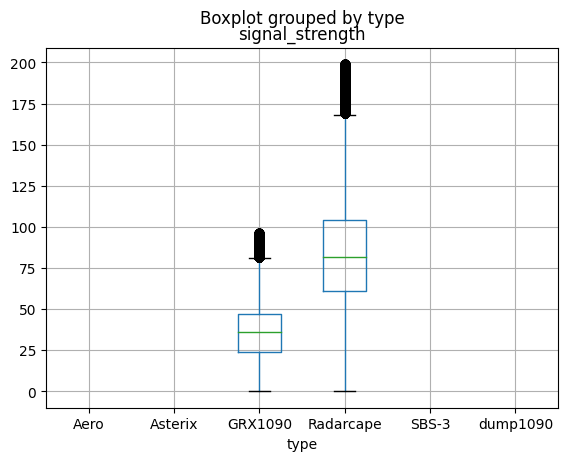

In [16]:
measurements_df.boxplot(column='signal_strength', by='type')